In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
def load_data(actual_file, prediction_files):
    """
    Loads the actual values and predictions from the given file paths.

    Parameters:
        actual_file (str): Path to the CSV file containing the actual values.
        prediction_files (list of str): List of paths to the CSV files containing predictions.

    Returns:
        tuple: A tuple containing:
            - pd.Series: Actual values.
            - dict: A dictionary where keys are file names and values are predictions as pd.Series.
    """
    # Load actual values
    actual = pd.read_csv(actual_file, index_col=0, parse_dates=True).squeeze()

    # Load predictions
    predictions = {
        file.split("/")[-1]: pd.read_csv(file, index_col=0, parse_dates=True).squeeze()
        for file in prediction_files
    }

    return actual, predictions

# Example usage for AAPL
actual_aapl_file = "../../data/input_data_splits/aapl_y_test.csv"
prediction_files_aapl = [
    "../../data/final_output_data/aaplARIMApred.csv",
    "../../data/final_output_data/aaplLSTMpred.csv",
    "../../data/final_output_data/aaplTransformerpred.csv"
]

aapl_actual, aapl_predictions = load_data(actual_aapl_file, prediction_files_aapl)

# Example usage for JNJ
actual_jnj_file = "../../data/input_data_splits/jnj_y_test.csv"
prediction_files_jnj = [
    "../../data/final_output_data/jnjARIMApred.csv",
    "../../data/final_output_data/jnjLSTMpred.csv",
    "../../data/final_output_data/jnjTransformerpred.csv"
]

jnj_actual, jnj_predictions = load_data(actual_jnj_file, prediction_files_jnj)

# Print the loaded data
print("AAPL Actual:\n", aapl_actual.head())
print("\nAAPL Predictions:\n", {name: pred.head() for name, pred in aapl_predictions.items()})



AAPL Actual:
 924    177.570007
925    176.649994
926    179.229996
927    181.820007
928    182.889999
Name: Close, dtype: float64

AAPL Predictions:
 {'aaplARIMApred.csv': Date
2023-11-02    176.987519
2023-11-03    176.898996
2023-11-06    176.810641
2023-11-07    176.722453
2023-11-08    176.634433
Name: 0, dtype: float64, 'aaplLSTMpred.csv': Date
2023-11-08    179.49770
2023-11-09    180.21442
2023-11-10    181.36996
2023-11-13    181.72385
2023-11-14    183.19066
Name: Predicted_Close_Inv, dtype: float64, 'aaplTransformerpred.csv': Date
2023-11-08    172.27356
2023-11-09    172.33987
2023-11-10    173.44385
2023-11-13    174.06790
2023-11-14    174.15637
Name: predicted_closing_price, dtype: float64}


/var/folders/dy/xb1k0n550lv3_x9fkj8wnv3c0000gn/T/ipykernel_48737/2444750475.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  actual = pd.read_csv(actual_file, index_col=0, parse_dates=True).squeeze()
/var/folders/dy/xb1k0n550lv3_x9fkj8wnv3c0000gn/T/ipykernel_48737/2444750475.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  actual = pd.read_csv(actual_file, index_col=0, parse_dates=True).squeeze()


In [3]:
# Print sequence lengths for AAPL
print("AAPL Sequence Lengths:")
print(f"Actual: {len(aapl_actual)}")
for name, pred in aapl_predictions.items():
    print(f"{name}: {len(pred)}")

# Print sequence lengths for JNJ
print("\nJNJ Sequence Lengths:")
print(f"Actual: {len(jnj_actual)}")
for name, pred in jnj_predictions.items():
    print(f"{name}: {len(pred)}")

AAPL Sequence Lengths:
Actual: 231
aaplARIMApred.csv: 231
aaplLSTMpred.csv: 227
aaplTransformerpred.csv: 227

JNJ Sequence Lengths:
Actual: 231
jnjARIMApred.csv: 231
jnjLSTMpred.csv: 227
jnjTransformerpred.csv: 227


In [4]:
# Determine the shortest length for AAPL and JNJ
min_aapl_length = min([len(aapl_actual)] + [len(pred) for pred in aapl_predictions.values()])
min_jnj_length = min([len(jnj_actual)] + [len(pred) for pred in jnj_predictions.values()])

In [5]:
def trim_to_shortest_and_match_dates(actual, predictions, min_length):
    """
    Trims the actual and prediction sequences to the shortest length and matches the actual index to prediction dates.

    Parameters:
        actual (pd.Series): Actual values.
        predictions (dict): Dictionary of prediction Series.
        min_length (int): The target length to trim to.

    Returns:
        tuple: Trimmed actual and predictions.
    """
    # Trim actual and predictions to the shortest length
    actual_trimmed = actual.iloc[-min_length:]
    predictions_trimmed = {name: pred.iloc[-min_length:] for name, pred in predictions.items()}

    # Match actual index to the first prediction's index
    actual_trimmed.index = predictions_trimmed[list(predictions_trimmed.keys())[0]].index

    return actual_trimmed, predictions_trimmed

In [6]:
aapl_actual_trimmed, aapl_predictions_trimmed = trim_to_shortest_and_match_dates(aapl_actual, aapl_predictions, min_aapl_length)
jnj_actual_trimmed, jnj_predictions_trimmed = trim_to_shortest_and_match_dates(jnj_actual, jnj_predictions, min_jnj_length)

# Print the lengths after trimming
print("\nAAPL Sequence Lengths After Trimming:")
print(f"Actual: {len(aapl_actual_trimmed)}")
for name, pred in aapl_predictions_trimmed.items():
    print(f"{name}: {len(pred)}")

print("\nJNJ Sequence Lengths After Trimming:")
print(f"Actual: {len(jnj_actual_trimmed)}")
for name, pred in jnj_predictions_trimmed.items():
    print(f"{name}: {len(pred)}")


AAPL Sequence Lengths After Trimming:
Actual: 227
aaplARIMApred.csv: 227
aaplLSTMpred.csv: 227
aaplTransformerpred.csv: 227

JNJ Sequence Lengths After Trimming:
Actual: 227
jnjARIMApred.csv: 227
jnjLSTMpred.csv: 227
jnjTransformerpred.csv: 227


In [7]:
print("\nAAPL Trimmed Data:")
print("Actual:")
print(aapl_actual_trimmed.head())
for name, pred in aapl_predictions_trimmed.items():
    print(f"{name}:")
    print(pred.head())



AAPL Trimmed Data:
Actual:
Date
2023-11-08    182.889999
2023-11-09    182.410004
2023-11-10    186.399994
2023-11-13    184.800003
2023-11-14    187.440002
Name: Close, dtype: float64
aaplARIMApred.csv:
Date
2023-11-08    176.634433
2023-11-09    176.546580
2023-11-10    176.458893
2023-11-13    176.371373
2023-11-14    176.284018
Name: 0, dtype: float64
aaplLSTMpred.csv:
Date
2023-11-08    179.49770
2023-11-09    180.21442
2023-11-10    181.36996
2023-11-13    181.72385
2023-11-14    183.19066
Name: Predicted_Close_Inv, dtype: float64
aaplTransformerpred.csv:
Date
2023-11-08    172.27356
2023-11-09    172.33987
2023-11-10    173.44385
2023-11-13    174.06790
2023-11-14    174.15637
Name: predicted_closing_price, dtype: float64


In [8]:
print("\nJNJ Trimmed Data:")
print("Actual:")
print(jnj_actual_trimmed.head())
for name, pred in jnj_predictions_trimmed.items():
    print(f"{name}:")
    print(pred.head())


JNJ Trimmed Data:
Actual:
Date
2023-11-08    150.350006
2023-11-09    147.419998
2023-11-10    147.250000
2023-11-13    147.630005
2023-11-14    147.660004
Name: Close, dtype: float64
jnjARIMApred.csv:
Date
2023-11-08    150.238506
2023-11-09    150.240225
2023-11-10    150.239713
2023-11-13    150.239913
2023-11-14    150.239848
Name: 0, dtype: float64
jnjLSTMpred.csv:
Date
2023-11-08    153.34203
2023-11-09    152.97680
2023-11-10    152.10344
2023-11-13    151.41167
2023-11-14    150.75511
Name: Predicted_Close_Inv, dtype: float64
jnjTransformerpred.csv:
Date
2023-11-08    161.32220
2023-11-09    159.76506
2023-11-10    159.29617
2023-11-13    160.14250
2023-11-14    159.60452
Name: predicted_closing_price, dtype: float64


In [9]:
# Function to calculate metrics
def calculate_metrics(actual, predictions):
    metrics = {}
    for model_name, pred in predictions.items():
        mae = mean_absolute_error(actual, pred)
        mse = mean_squared_error(actual, pred)
        rmse = mse ** 0.5
        r2 = r2_score(actual, pred)
        metrics[model_name] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "R^2": r2}
    return pd.DataFrame(metrics).T

In [10]:
# Calculate metrics for AAPL and JNJ
aapl_metrics = calculate_metrics(aapl_actual_trimmed, aapl_predictions_trimmed)
jnj_metrics = calculate_metrics(jnj_actual_trimmed, jnj_predictions_trimmed)
# Print metrics
print("\nAAPL Metrics:")
print(aapl_metrics)

print("\nJNJ Metrics:")
print(jnj_metrics)


AAPL Metrics:
                               MAE          MSE       RMSE       R^2
aaplARIMApred.csv        29.087922  1388.559909  37.263386 -2.474184
aaplLSTMpred.csv          3.764993    24.336489   4.933203  0.939110
aaplTransformerpred.csv  14.363693   290.772106  17.052041  0.272487

JNJ Metrics:
                             MAE        MSE      RMSE       R^2
jnjARIMApred.csv        6.799403  65.270226  8.078999 -0.705783
jnjLSTMpred.csv         1.896600   5.630596  2.372888  0.852849
jnjTransformerpred.csv  8.406333  86.190845  9.283902 -1.252526


In [11]:
# Plot actual vs predictions
def plot_actual_vs_predictions(actual, predictions, title):
    plt.figure(figsize=(12, 6))
    plt.plot(actual.index, actual, label="Actual", color="black", linewidth=2)
    for model_name, pred in predictions.items():
        plt.plot(pred.index, pred, label=model_name, linewidth=1.5)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

In [12]:
# Plot residuals
def plot_residuals(actual, predictions, title):
    plt.figure(figsize=(12, 6))
    for model_name, pred in predictions.items():
        residuals = actual - pred
        plt.plot(residuals.index, residuals, label=f"Residuals ({model_name})")
    plt.axhline(0, color="black", linestyle="--", linewidth=1)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Residuals")
    plt.legend()
    plt.grid(True)
    plt.show()

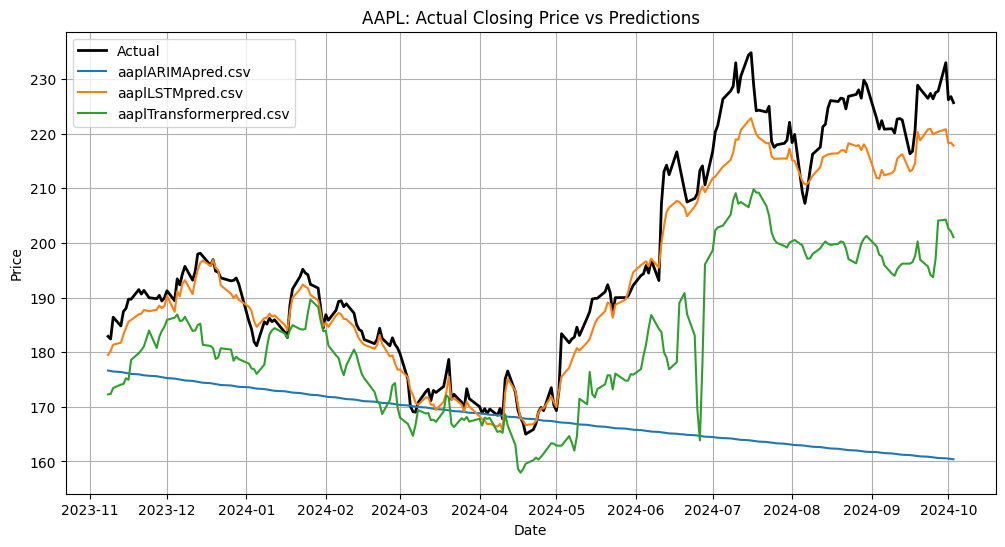

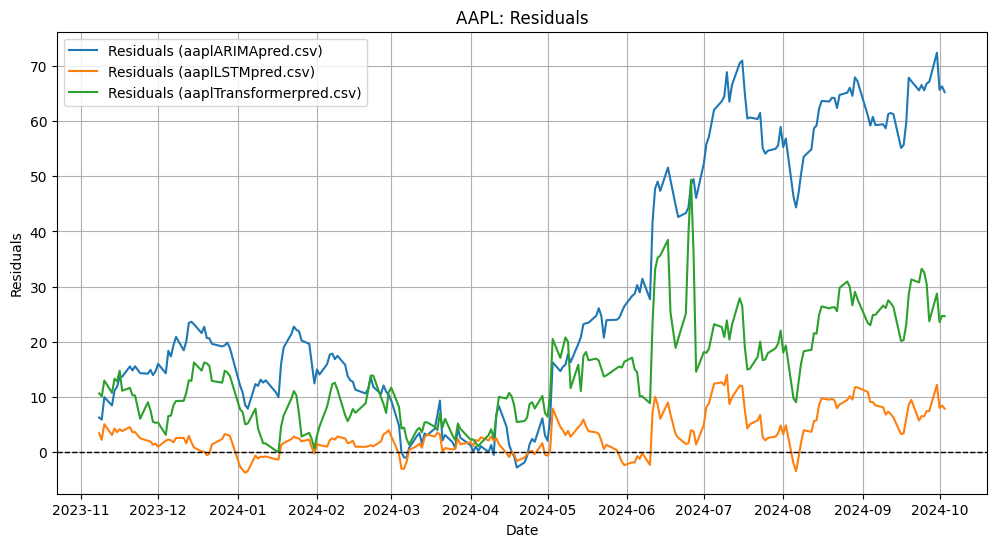

In [13]:
# Visualize AAPL and JNJ data
plot_actual_vs_predictions(aapl_actual_trimmed, aapl_predictions_trimmed, "AAPL: Actual Closing Price vs Predictions")
plot_residuals(aapl_actual_trimmed, aapl_predictions_trimmed, "AAPL: Residuals")

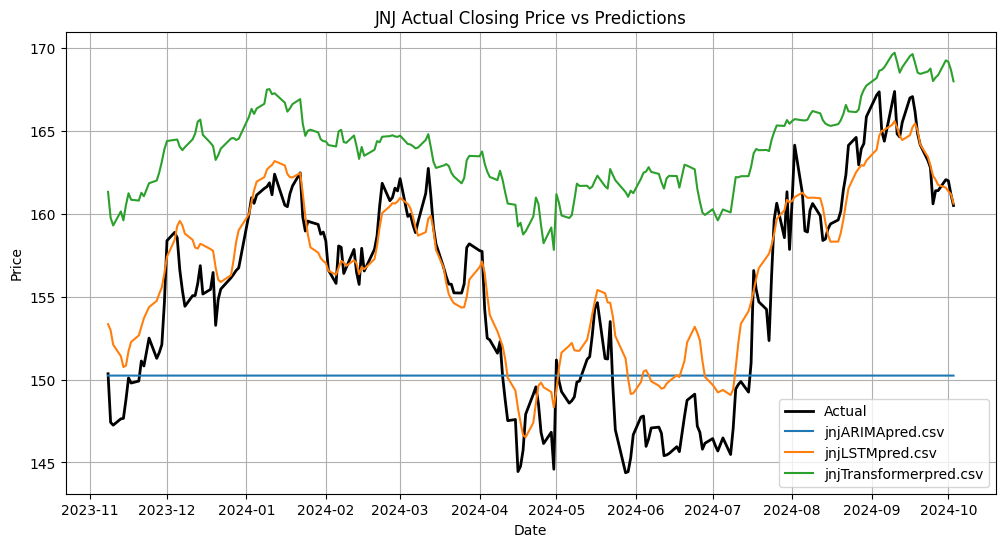

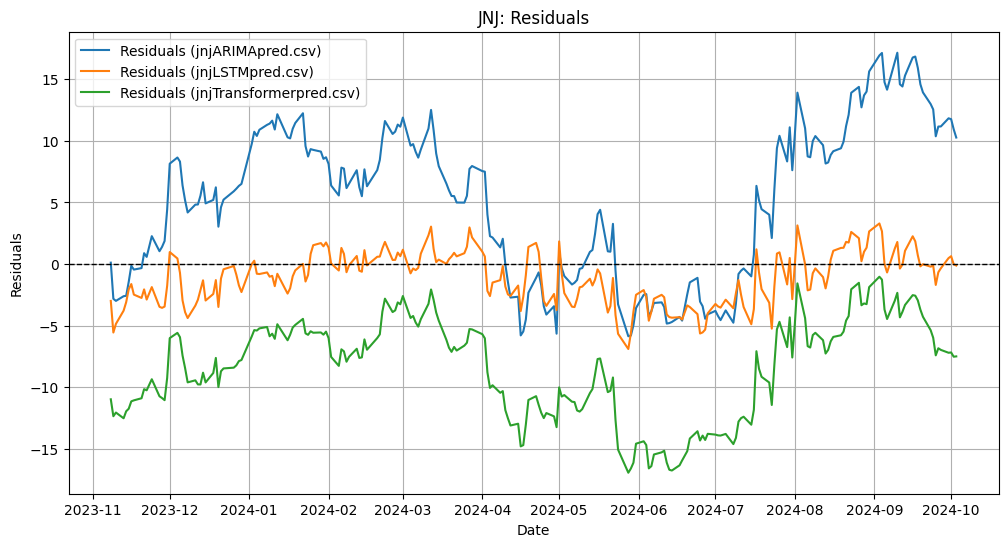

In [14]:
plot_actual_vs_predictions(jnj_actual_trimmed, jnj_predictions_trimmed, "JNJ Actual Closing Price vs Predictions")
plot_residuals(jnj_actual_trimmed, jnj_predictions_trimmed, "JNJ: Residuals")

In [15]:
def plot_error_distribution(actual, predictions, title):
    plt.figure(figsize=(12, 6))
    for model_name, pred in predictions.items():
        residuals = actual - pred
        plt.hist(residuals, bins=30, alpha=0.6, label=f"{model_name}", density=True)
    plt.title(title)
    plt.xlabel("Residuals")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()



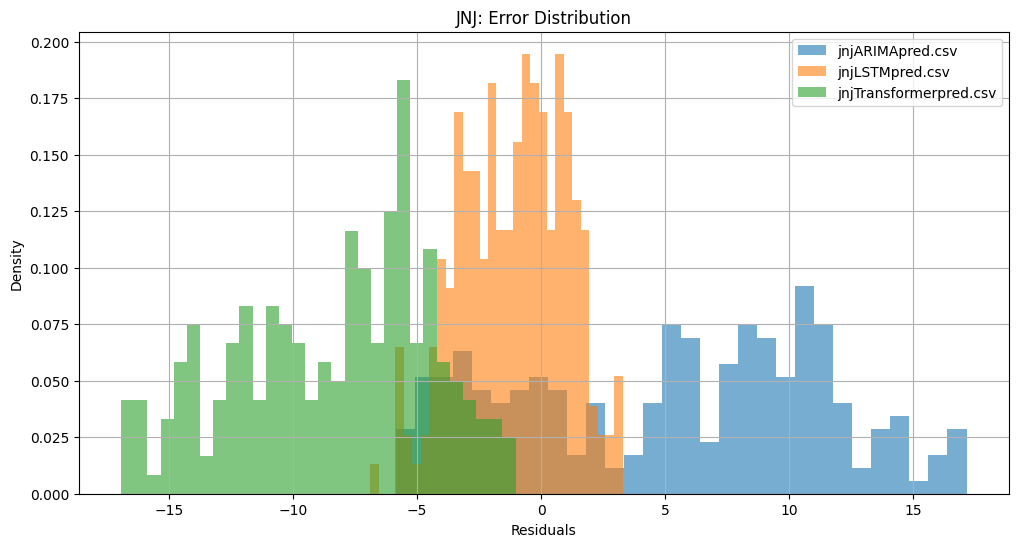

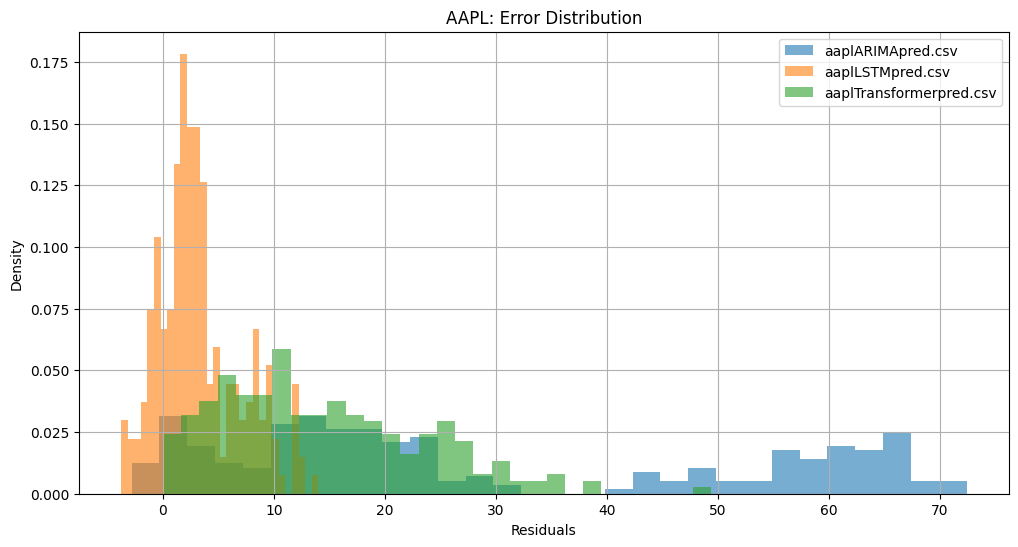

In [16]:
plot_error_distribution(jnj_actual_trimmed, jnj_predictions_trimmed, title="JNJ: Error Distribution")
plot_error_distribution(aapl_actual_trimmed, aapl_predictions_trimmed, title="AAPL: Error Distribution")

In [17]:
def plot_cumulative_returns(actual, predictions, title):
    plt.figure(figsize=(12, 6))
    actual_returns = (actual.pct_change() + 1).cumprod()
    plt.plot(actual_returns.index, actual_returns, label="Actual", linewidth=2, color="black")
    for model_name, pred in predictions.items():
        predicted_returns = (pred.pct_change() + 1).cumprod()
        plt.plot(predicted_returns.index, predicted_returns, label=model_name, linewidth=1.5)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns")
    plt.legend()
    plt.grid(True)
    plt.show()



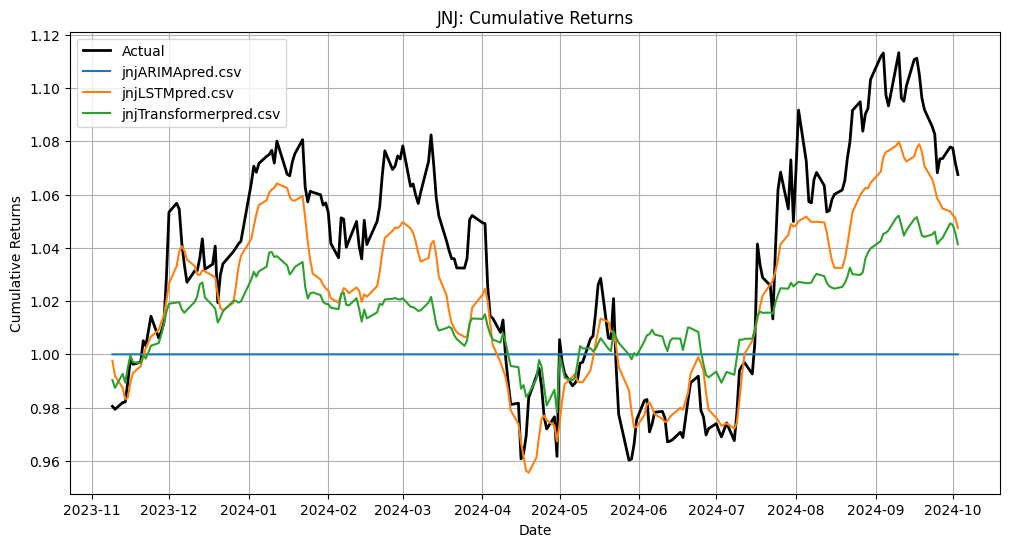

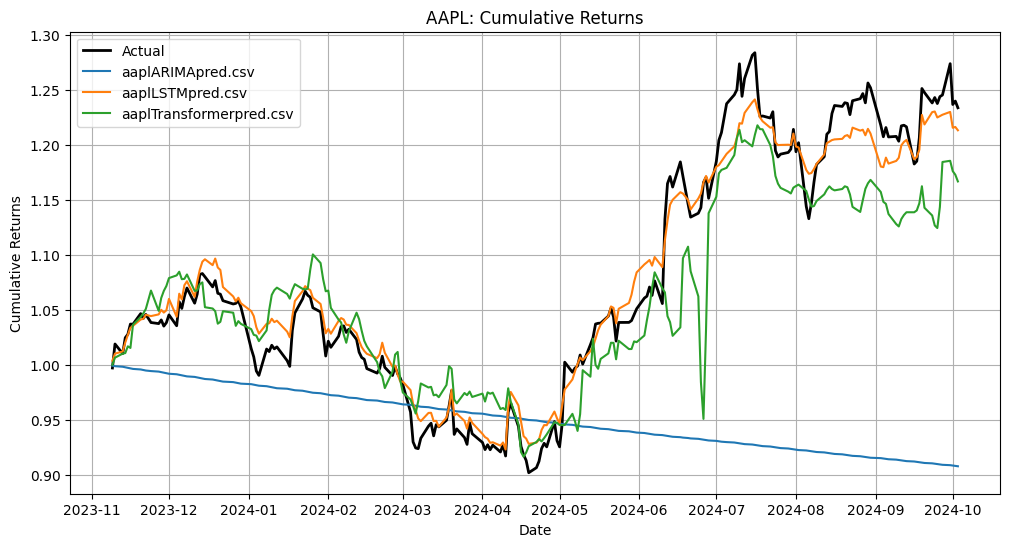

In [18]:
plot_cumulative_returns(jnj_actual_trimmed, jnj_predictions_trimmed, "JNJ: Cumulative Returns")
plot_cumulative_returns(aapl_actual_trimmed, aapl_predictions_trimmed, "AAPL: Cumulative Returns")

In [19]:
def plot_rolling_error(actual, predictions, metric, window, title):
    plt.figure(figsize=(12, 6))
    for model_name, pred in predictions.items():
        errors = actual - pred
        if metric == "RMSE":
            rolling_error = (errors ** 2).rolling(window).mean() ** 0.5
        elif metric == "MAE":
            rolling_error = errors.abs().rolling(window).mean()
        plt.plot(rolling_error.index, rolling_error, label=f"{model_name} ({metric})")
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(f"Rolling {metric}")
    plt.legend()
    plt.grid(True)
    plt.show()



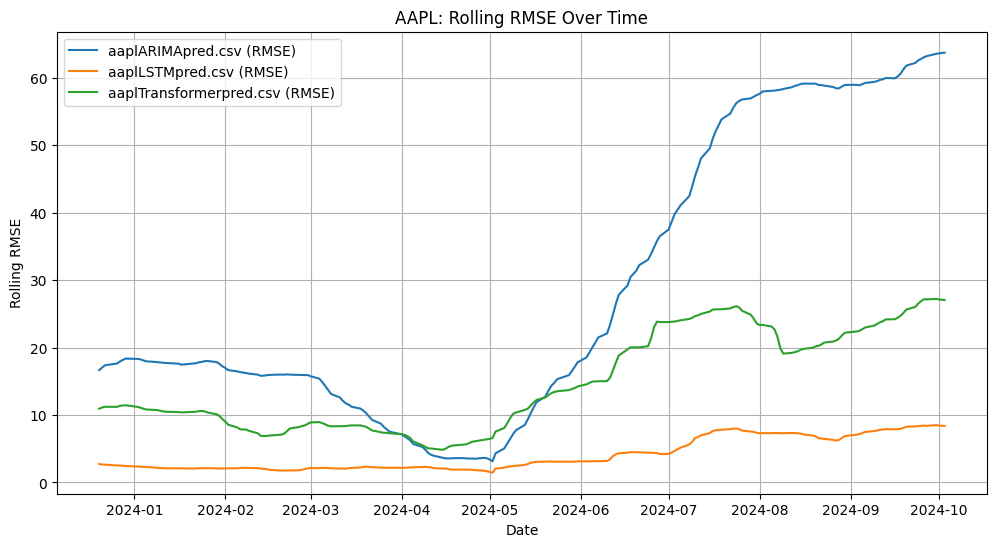

In [20]:
plot_rolling_error(aapl_actual_trimmed, aapl_predictions_trimmed, metric="RMSE", window=30, title="AAPL: Rolling RMSE Over Time")


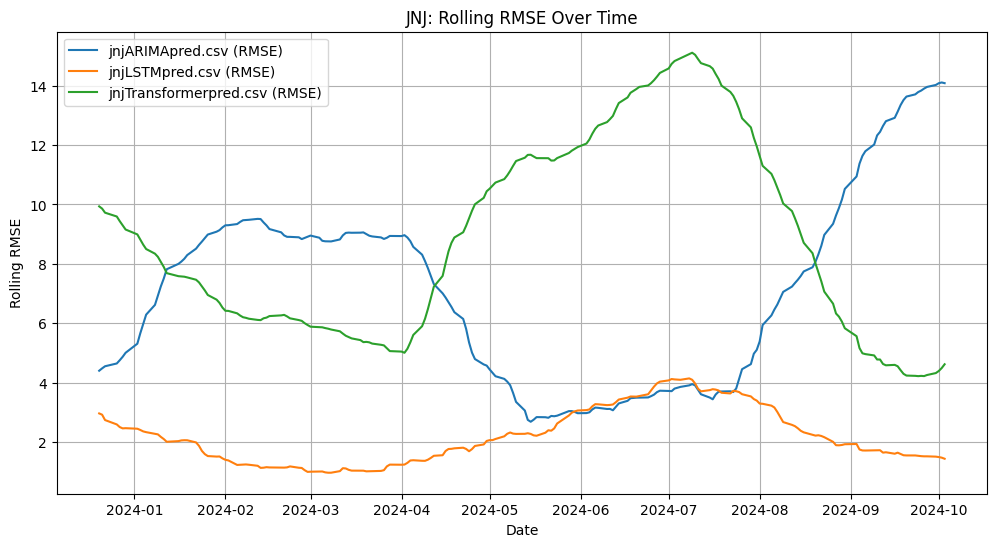

In [21]:
plot_rolling_error(jnj_actual_trimmed, jnj_predictions_trimmed, metric="RMSE", window=30, title="JNJ: Rolling RMSE Over Time")
